In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#import shap


warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.max_columns = 500
plt.style.use("fast")

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.columns = [col.lower().replace(" ","_") for col in train.columns]
test.columns = [col.lower().replace(" ","_") for col in test.columns]
train = train.drop(["id"], axis=1)
test = test.drop(["id"], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   name                                   140700 non-null  object 
 1   gender                                 140700 non-null  object 
 2   age                                    140700 non-null  float64
 3   city                                   140700 non-null  object 
 4   working_professional_or_student        140700 non-null  object 
 5   profession                             104070 non-null  object 
 6   academic_pressure                      27897 non-null   float64
 7   work_pressure                          112782 non-null  float64
 8   cgpa                                   27898 non-null   float64
 9   study_satisfaction                     27897 non-null   float64
 10  job_satisfaction                       112790 non-null  

In [5]:
train.describe().round(2).style.format(precision=2).background_gradient(
    cmap="Blues"
)

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work/study_hours,financial_stress,depression
count,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00
mean,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18
std,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


In [6]:
train.describe(include="object")

,name,gender,city,working_professional_or_student,profession,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,family_history_of_mental_illness
count,140700,140700,140700,140700,104070,140700,140696,140698,140700,140700
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77464,6591,112799,24906,38784,49705,14729,71138,70758


In [7]:
def new_feats(df):
    df = (
        df.assign(satisfaction_by_work=df["work_pressure"] / df["job_satisfaction"])
        .assign(
            satisfaction_by_study=df["academic_pressure"] / df["study_satisfaction"]
        )
        .assign(age_work_satisfaction=df["age"] / df["job_satisfaction"])
        .assign(cgpa_study=df["cgpa"] / df["academic_pressure"])
    )
    return df

In [8]:
train = new_feats(train).copy()
test = new_feats(test).copy()
print("*************************************")
print("----------train Shape------------")
print(train.shape)
print("*************************************")
print("----------test Shape------------")
print(test.shape)
print("*************************************")

*************************************
----------train Shape------------
(140700, 23)
*************************************
----------test Shape------------
(93800, 22)
*************************************


In [9]:
num_feats = train.select_dtypes(include="float64").columns
obj_feats = train.select_dtypes(include="object").columns
target = train.select_dtypes(include="int64").columns
print("*************************************")
print("----------Numerical Featuers---------")
print(num_feats)
print("*************************************")
print("----------Object Featuers------------")
print(obj_feats)
print("*************************************")
print("----------Target Variable------------")
print(target)
print("*************************************")

*************************************
----------Numerical Featuers---------
Index(['age', 'academic_pressure', 'work_pressure', 'cgpa',
       'study_satisfaction', 'job_satisfaction', 'work/study_hours',
       'financial_stress', 'satisfaction_by_work', 'satisfaction_by_study',
       'age_work_satisfaction', 'cgpa_study'],
      dtype='object')
*************************************
----------Object Featuers------------
Index(['name', 'gender', 'city', 'working_professional_or_student',
       'profession', 'sleep_duration', 'dietary_habits', 'degree',
       'have_you_ever_had_suicidal_thoughts_?',
       'family_history_of_mental_illness'],
      dtype='object')
*************************************
----------Target Variable------------
Index(['depression'], dtype='object')
*************************************


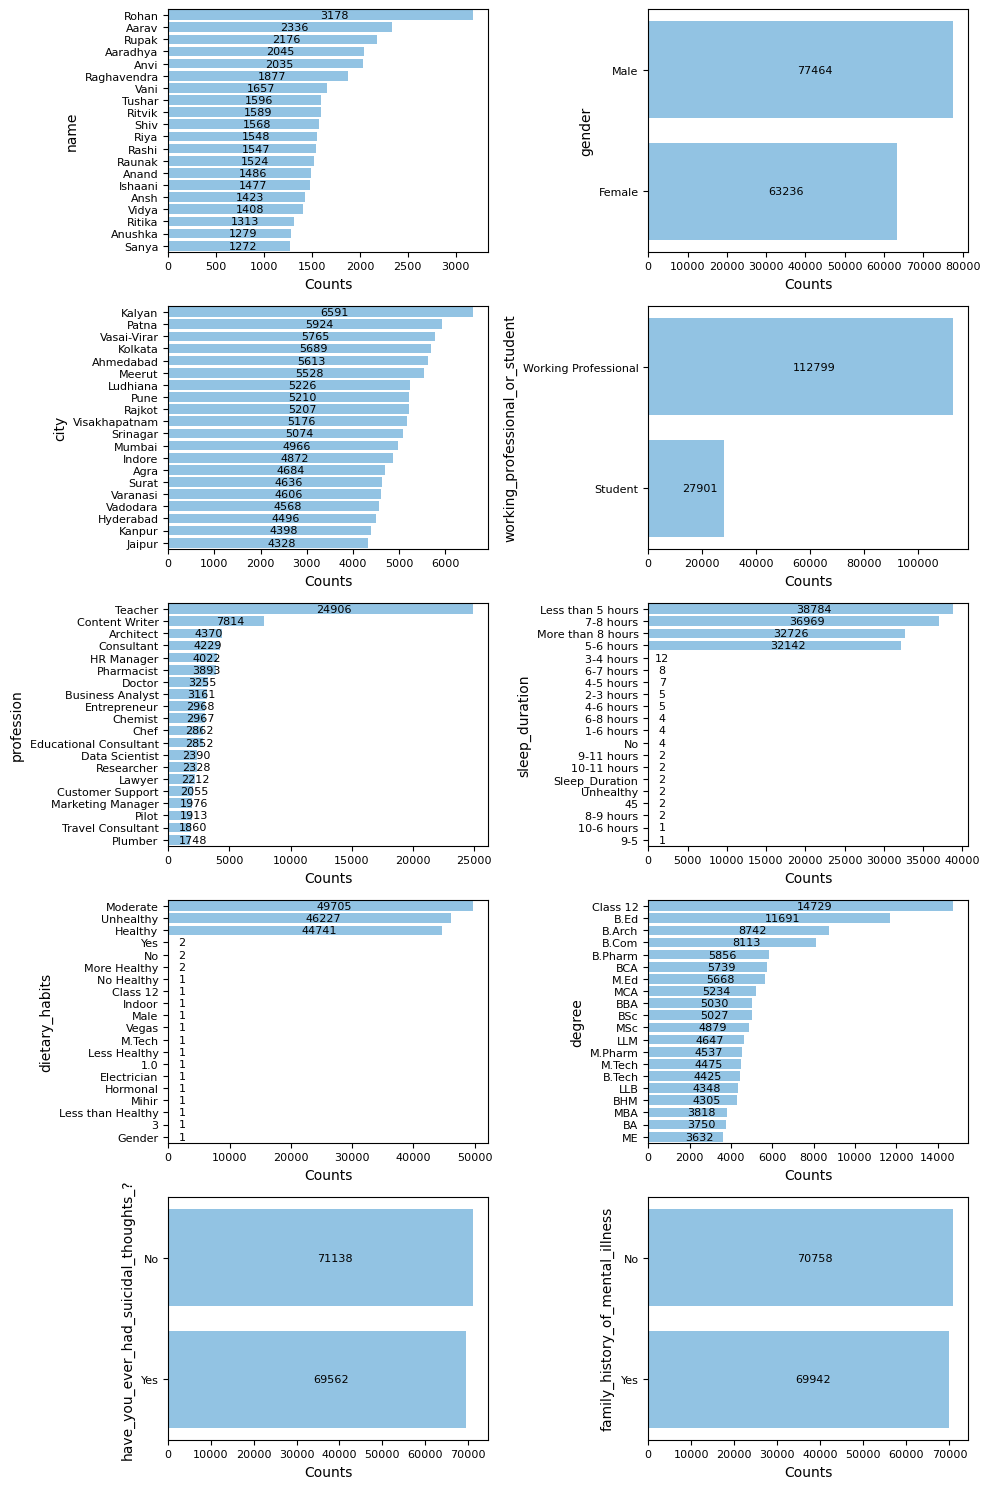

In [10]:
fig = plt.figure(figsize=(10, 15))

for i, feature in enumerate(obj_feats):
    ax = fig.add_subplot(5, 2, i + 1)
    df_temp = train[feature].value_counts().nlargest(20).reset_index()
    sns.barplot(df_temp, y=feature, x="count", color="#66b7ee", orient="h", alpha=0.8)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

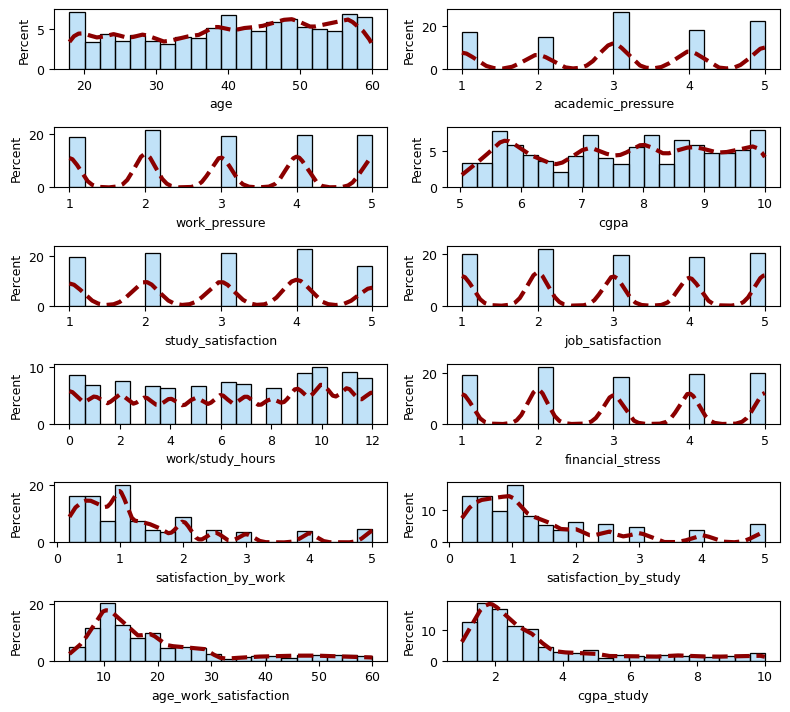

In [11]:
fig = plt.figure(figsize=(8, 8))

for i, feature in enumerate(num_feats):
    ax = fig.add_subplot(7, 2, i + 1)
    sns.histplot(
        train[feature],
        stat="percent",
        kde=True,
        bins=20,
        alpha=0.4,
        color="#66b7ee",
        line_kws={"lw": 3, "linestyle": "dashed"},
    ).lines[0].set_color("darkred")
    plt.tick_params(axis="both", labelsize=9)
    plt.ylabel("Percent", fontsize=9)
    plt.xlabel(feature, fontsize=9)


fig.tight_layout()
plt.show()

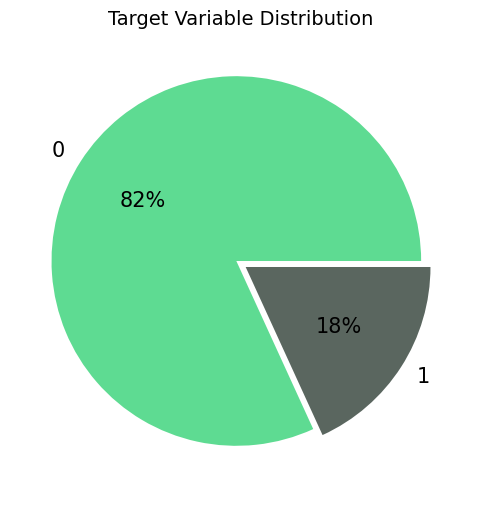

In [12]:
target_colors = [
    "#5EDB92",
    "#5A665F",
]
plt.figure(figsize=(6, 6))
plt.pie(
    train["depression"].value_counts(),
    labels=train["depression"].value_counts().index,
    textprops={"fontsize": 15, "color": "black"},
    colors=target_colors,
    autopct="%.0f%%",
    explode=[0.03, 0.03],
)
plt.title("Target Variable Distribution", fontsize=14)
plt.show()

## Feature Transform

In [13]:
deg = train["degree"].value_counts()[0:27].reset_index()["degree"].to_list()
train["degree"] = np.where(train["degree"].isin(deg), train["degree"], "Other")
test["degree"] = np.where(test["degree"].isin(deg), test["degree"], "Other")
print("****************************")
print("----------train--------")
print(train["degree"].value_counts())
print("****************************")
print("----------test-----------")
print(test["degree"].value_counts())
print("****************************")

****************************
----------train--------
degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Other         116
Name: count, dtype: int64
****************************
----------test-----------
degree
Class 12    9812
B.Ed        7762
B.Arch      6037
B.Com       5439
B.Pharm     3987
BCA         3869
M.Ed        3707
MCA         3438
BBA         3387
BSc         3314
LLM         3133
MSc         3096
M.Tech      3017
M.Pharm     2995
LLB         2938
B.Tech      2885
BHM         2776
BA          2490
MBA         2470
ME          2391
MD      

In [14]:
def catplt(x_var, y_var, aspect = 4):
    gs = sns.catplot(
        data=train,
        x=x_var,
        y=y_var,
        kind="count",
        hue="depression",
        #col=x_var,
        height=2,
        aspect=aspect,
        sharey=False,
        #col_wrap=2,
        palette=target_colors,
        legend_out=False,
        legend="auto",
        width=0.5,
    )
    for ax in gs.axes.ravel():
        for i in ax.containers:
            ax.bar_label(i, label_type="edge", fontsize=8)
            ax.set_xlabel("", fontsize=12)
            ax.set_ylabel("", fontsize=12)
            ax.tick_params(axis="both", labelsize=8)
            gs._legend.remove()
            gs.set_titles(size=8)

    plt.legend(title="Target", title_fontsize=8, fontsize=8, loc="best")
    plt.show()

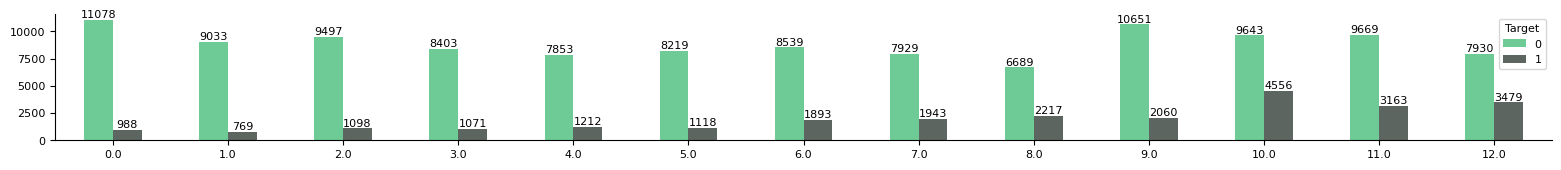

In [15]:
catplt(x_var="work/study_hours", y_var=None, aspect= 8)

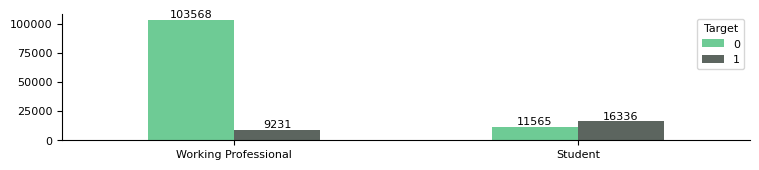

In [16]:
catplt(x_var="working_professional_or_student", y_var=None)

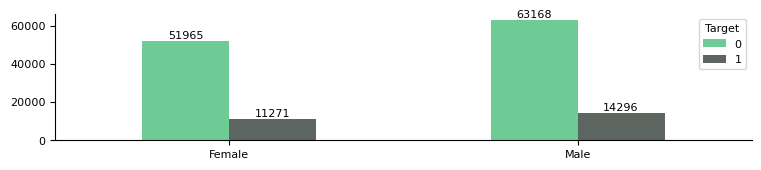

In [17]:
catplt(x_var="gender", y_var=None)

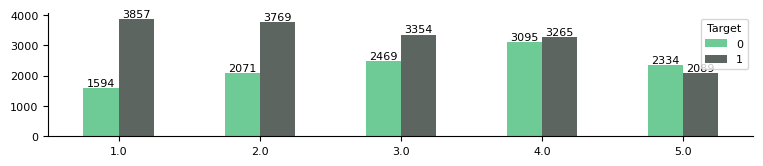

In [18]:
catplt(x_var="study_satisfaction", y_var=None)

In [19]:
train["degree"].value_counts(normalize=True)

degree
Class 12    0.104684
B.Ed        0.083092
B.Arch      0.062132
B.Com       0.057662
B.Pharm     0.041620
BCA         0.040789
M.Ed        0.040284
MCA         0.037200
BBA         0.035750
BSc         0.035729
MSc         0.034677
LLM         0.033028
M.Pharm     0.032246
M.Tech      0.031805
B.Tech      0.031450
LLB         0.030903
BHM         0.030597
MBA         0.027136
BA          0.026652
ME          0.025814
MD          0.024044
MHM         0.023355
BE          0.022061
PhD         0.022054
M.Com       0.021990
MBBS        0.021905
MA          0.020519
Other       0.000824
Name: proportion, dtype: float64

In [20]:
deg = train["degree"].value_counts()[0:27].reset_index()["degree"].to_list()
train["degree"] = np.where(train["degree"].isin(deg), train["degree"], "Other")
test["degree"] = np.where(test["degree"].isin(deg), test["degree"], "Other")
print("****************************")
print("----------train--------")
print(train["degree"].value_counts())
print("****************************")
print("----------test-----------")
print(test["degree"].value_counts())
print("****************************")

****************************
----------train--------
degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Other         116
Name: count, dtype: int64
****************************
----------test-----------
degree
Class 12    9812
B.Ed        7762
B.Arch      6037
B.Com       5439
B.Pharm     3987
BCA         3869
M.Ed        3707
MCA         3438
BBA         3387
BSc         3314
LLM         3133
MSc         3096
M.Tech      3017
M.Pharm     2995
LLB         2938
B.Tech      2885
BHM         2776
BA          2490
MBA         2470
ME          2391
MD      

In [21]:
dh = train["dietary_habits"].value_counts()[0:3].reset_index()["dietary_habits"].to_list()
train["dietary_habits"] = np.where(train["dietary_habits"].isin(dh), train["dietary_habits"], "Moderate")
test["dietary_habits"] = np.where(test["dietary_habits"].isin(dh), test["dietary_habits"], "Moderate")
print("****************************")
print("----------train---------")
print(train["dietary_habits"].value_counts())
print("****************************")
print("----------test------------")
print(test["dietary_habits"].value_counts())
print("****************************")

****************************
----------train---------
dietary_habits
Moderate     49732
Unhealthy    46227
Healthy      44741
Name: count, dtype: int64
****************************
----------test------------
dietary_habits
Moderate     33048
Unhealthy    30786
Healthy      29966
Name: count, dtype: int64
****************************


In [22]:
sleep_d =train["sleep_duration"].value_counts()[0:4].reset_index()["sleep_duration"].to_list()
train["sleep_duration"] = np.where(train["sleep_duration"].isin(sleep_d), train["sleep_duration"], "1-8")
test["sleep_duration"] = np.where(test["sleep_duration"].isin(sleep_d), test["sleep_duration"], "1-8")
print("****************************")
print("----------train---------")
print(train["sleep_duration"].value_counts())
print("****************************")
print("----------test------------")
print(test["sleep_duration"].value_counts())
print("****************************")

****************************
----------train---------
sleep_duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
1-8                     79
Name: count, dtype: int64
****************************
----------test------------
sleep_duration
Less than 5 hours    25661
7-8 hours            24491
More than 8 hours    22190
5-6 hours            21404
1-8                     54
Name: count, dtype: int64
****************************


2.    El autor podría considerar que las categorías más frecuentes después de la principal ([1:35]) son más representativas de la diversidad en la variable Profession.
    Por ejemplo, al agrupar las categorías menos frecuentes como "Other", busca evitar que Teacher acapare el análisis, dejando que otras categorías tengan mayor impacto.

3. Optimización para modelos específicos:

    En algunos algoritmos (e.g., árboles de decisión o modelos basados en gradiente), una categoría extremadamente frecuente puede reducir la capacidad del modelo para dividir de manera efectiva los datos en ramas significativas.
    Al eliminar Teacher, el autor podría estar intentando mejorar la discriminación entre las demás categorías.

In [23]:
pro = train["profession"].value_counts()[1:35].reset_index()["profession"].to_list()
train["profession"] = np.where(train["profession"].isin(pro), train["profession"], "Other")
test["profession"] = np.where(test["profession"].isin(pro), test["profession"], "Other")
print("****************************")
print("----------train---------")
print(train["profession"].value_counts())
print("****************************")
print("----------test------------")
print(test["profession"].value_counts())
print("****************************")

****************************
----------train---------
profession
Other                     61586
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Account

In [26]:
df_sample_n = (
    train.groupby("depression")
    .sample(frac=0.01, random_state=42)
    .reset_index(drop=True)
)
pair_cols = num_feats.append(target)
# sns.pairplot(
#     df_sample_n[pair_cols],
#     hue="Depression",
#     kind="scatter",
#     diag_kind="kde",
#     palette=target_colors,
#     height=2,
#     aspect=1.5,
#     plot_kws=dict(s=10),
# )

# plt.show()

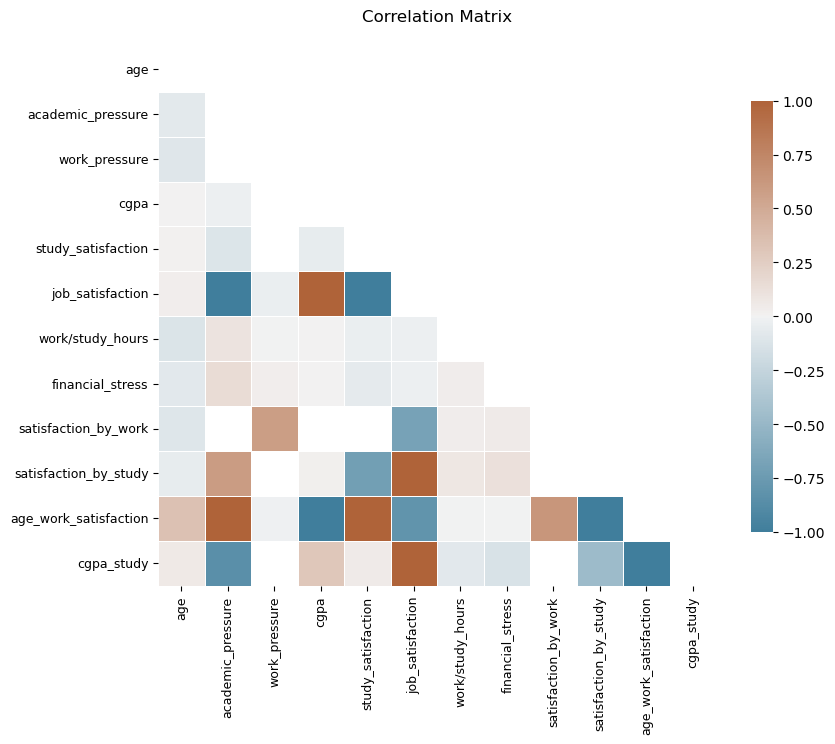

In [24]:
plt.style.use("default")
corr_mat = train[num_feats].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    corr_mat,
    mask=mask,
    cbar=True,
    cmap=cmap,
    center=0,
    square=False,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix\n")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Logistic Regression

In [27]:
logi_train = train.fillna("0")
logi_test = test.fillna("0")
logi_train = logi_train[pair_cols]
logit_num_feats_test = pair_cols[:-1]
logi_test = logi_test[logit_num_feats_test]
logi_y = logi_train["depression"]
logi_X = logi_train.drop(["depression"], axis=1)
logi_X_train, logi_X_test, logi_y_train, logi_y_test = train_test_split(
    logi_X, logi_y, test_size=0.3, random_state=42)
logi_reg = LogisticRegression(max_iter = 2000)
logi_reg.fit(logi_X_train, logi_y_train)
logi_y_pred = logi_reg.predict(logi_X_test)
print('Accuracy of logistic regression classifier on validation set: {:.4f}'.format(logi_reg.score(logi_X_test, logi_y_test)))

Accuracy of logistic regression classifier on validation set: 0.9191


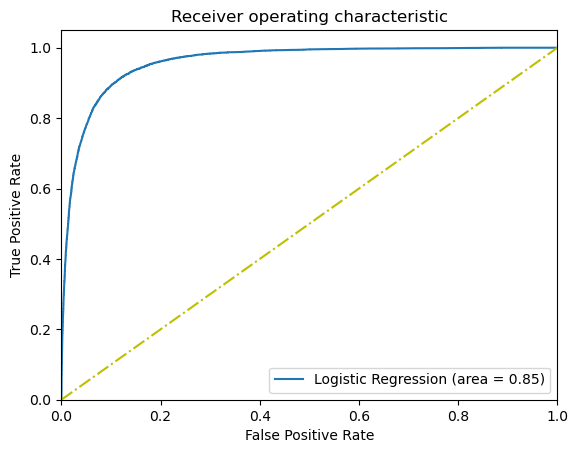

In [28]:
logit_roc_auc = roc_auc_score(logi_y_test, logi_reg.predict(logi_X_test))
fpr, tpr, thresholds = roc_curve(logi_y_test, logi_reg.predict_proba(logi_X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'y-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(logi_y_test, logi_y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     34434
           1       0.80      0.75      0.77      7776

    accuracy                           0.92     42210
   macro avg       0.87      0.85      0.86     42210
weighted avg       0.92      0.92      0.92     42210



In [30]:
from sklearn.metrics import classification_report
print(classification_report(logi_y_test, logi_y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     34434
           1       0.80      0.75      0.77      7776

    accuracy                           0.92     42210
   macro avg       0.87      0.85      0.86     42210
weighted avg       0.92      0.92      0.92     42210



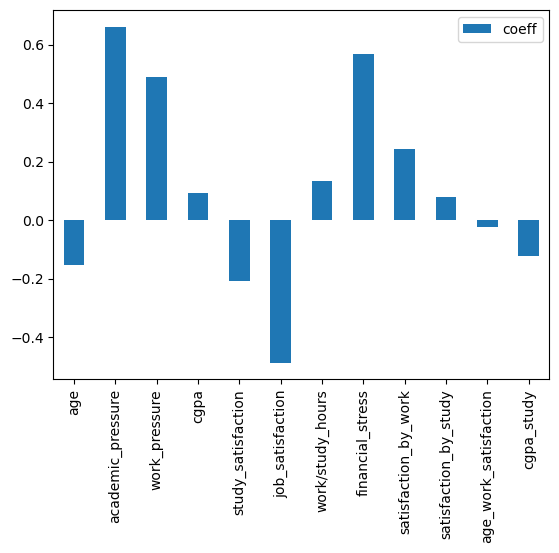

In [31]:
pd.DataFrame({'coeff': logi_reg.coef_[0]}, 
             index=logi_X.columns).plot(kind = "bar")
plt.show()

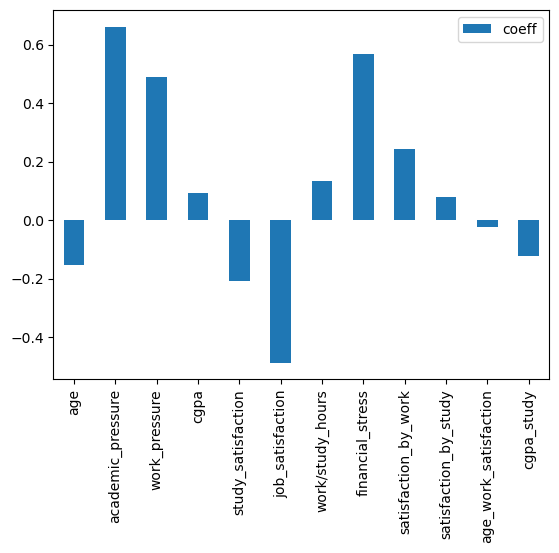

In [32]:
pd.DataFrame({'coeff': logi_reg.coef_[0]}, 
             index=logi_X.columns).plot(kind = "bar")
plt.show()

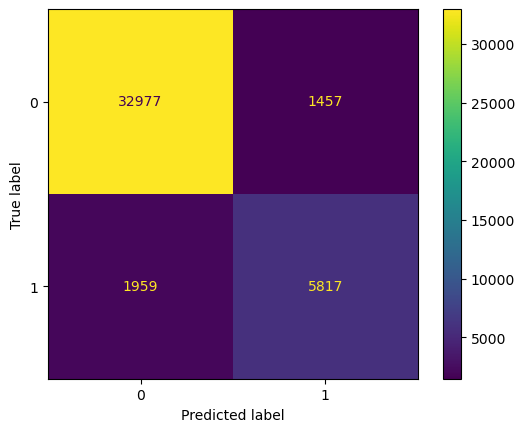

In [33]:
confusion_matrix = confusion_matrix(logi_y_test, logi_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [34]:
confusion_matrix = confusion_matrix(logi_y_test, logi_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

TypeError: 'numpy.ndarray' object is not callable

# CatBoost

In [35]:
cat_train = train.fillna("0")
cat_test = test.fillna("0")
cat_train[num_feats] = cat_train[num_feats].astype("float64")
cat_train[obj_feats] = cat_train[obj_feats].astype("string")
cat_train[target] = cat_train[target].astype("int64")
cat_test[num_feats] = cat_test[num_feats].astype("float64")
cat_test[obj_feats] = cat_test[obj_feats].astype("string")

In [36]:
y = cat_train["depression"]
X = cat_train.drop(["depression"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4
)
shap_df = (
    cat_train
    .groupby('depression')
    [cat_train.columns.tolist()]
    .apply(lambda x: x.sample(frac=0.02), include_groups=True)
    .reset_index(drop=True)
    .copy()
    )
y_shap = shap_df["depression"]
X_shap = shap_df.drop(["depression"], axis=1)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_shap, y_shap, test_size=0.2, random_state=1
)

In [ ]:
def objective(trial):
    # Espacio de búsqueda para los hiperparámetros
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 20.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
    }

    # Modelo de CatBoost
    model = CatBoostClassifier(**params, cat_features=list(obj_feats), verbose=False)

    # Evaluación usando validación cruzada
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score

# Crear un estudio con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_params = study.best_params
print(best_params)

In [37]:
best_params = {'iterations': 633,
 'learning_rate': 0.18918646362839026,
 'depth': 4,
 'colsample_bylevel': 0.9909843814690833,
 'subsample': 0.9778634549619083,
 'min_data_in_leaf': 1,
 'l2_leaf_reg': 10.504885456201343,
 'random_strength': 0.664861942866057}

In [38]:
print("Mejores parámetros encontrados:")
best_params

Mejores parámetros encontrados:


{'iterations': 633,
 'learning_rate': 0.18918646362839026,
 'depth': 4,
 'colsample_bylevel': 0.9909843814690833,
 'subsample': 0.9778634549619083,
 'min_data_in_leaf': 1,
 'l2_leaf_reg': 10.504885456201343,
 'random_strength': 0.664861942866057}

In [45]:
import shap
cat_interp = CatBoostClassifier(**best_params, verbose=True, cat_features=X[obj_feats].columns.values, early_stopping_rounds=200)
cat_interp.fit(X_train_shap, y_train_shap)
shap.initjs()
explainer = shap.TreeExplainer(cat_interp)
shap_values = explainer(X_train_shap)

0:	learn: 0.4618206	total: 2.55ms	remaining: 1.61s
1:	learn: 0.3431745	total: 4.49ms	remaining: 1.42s
2:	learn: 0.2803806	total: 6.2ms	remaining: 1.3s
3:	learn: 0.2381303	total: 7.93ms	remaining: 1.25s
4:	learn: 0.2247851	total: 10.5ms	remaining: 1.32s
5:	learn: 0.2066991	total: 12.4ms	remaining: 1.29s
6:	learn: 0.1966719	total: 14ms	remaining: 1.25s
7:	learn: 0.1876957	total: 15.7ms	remaining: 1.22s
8:	learn: 0.1830317	total: 17.2ms	remaining: 1.19s
9:	learn: 0.1768167	total: 18.9ms	remaining: 1.18s
10:	learn: 0.1710033	total: 20.5ms	remaining: 1.16s
11:	learn: 0.1668393	total: 22.2ms	remaining: 1.15s
12:	learn: 0.1644330	total: 23.6ms	remaining: 1.13s
13:	learn: 0.1623845	total: 25.2ms	remaining: 1.11s
14:	learn: 0.1601041	total: 26.6ms	remaining: 1.1s
15:	learn: 0.1580008	total: 28.1ms	remaining: 1.08s
16:	learn: 0.1552060	total: 30ms	remaining: 1.09s
17:	learn: 0.1521429	total: 31.5ms	remaining: 1.07s
18:	learn: 0.1512964	total: 32.9ms	remaining: 1.06s
19:	learn: 0.1498788	total: 3

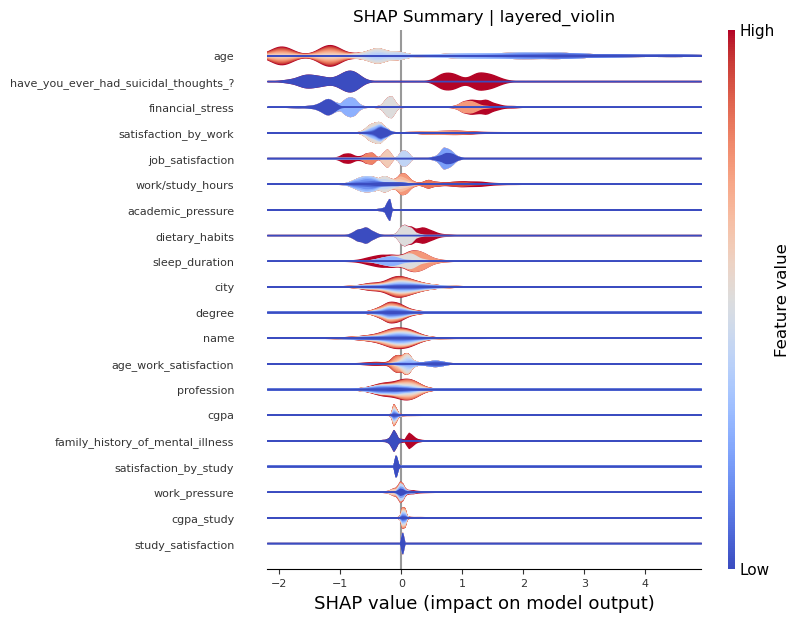

In [46]:
shap.plots.violin(shap_values, plot_type="layered_violin", show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary | layered_violin", fontsize=12)
plt.show()

In [47]:
cat_cv_last = StratifiedKFold(10, shuffle=True, random_state=42)
cat_cv_splits = cat_cv_last.split(X, y)
acc_scores = []
last_test_preds = []
X_test_pool = Pool(test, cat_features=X[obj_feats].columns.values)

In [48]:
for i, (cat_train_idx, valid_idx) in enumerate(cat_cv_splits):
    model_fold = CatBoostClassifier(**best_params)
    X_train_fold, X_valid_fold = X.loc[cat_train_idx], X.loc[valid_idx]
    y_train_fold, y_valid_fold = y.loc[cat_train_idx], y.loc[valid_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X[obj_feats].columns.values)
    X_valid_pool = Pool(X_valid_fold, y_valid_fold, cat_features=X[obj_feats].columns.values)
    model_fold.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=100)
    valid_pred = model_fold.predict(X_valid_pool)
    score = accuracy_score(y_valid_fold, valid_pred)
    acc_scores.append(score)
    test_pred = model_fold.predict_proba(X_test_pool)[:, 1]
    last_test_preds.append(test_pred)
    print(f'Fold {i + 1} Accuracy Score: {score}')

Fold 1 Accuracy Score: 0.9392324093816631
Fold 2 Accuracy Score: 0.9407960199004975
Fold 3 Accuracy Score: 0.937953091684435
Fold 4 Accuracy Score: 0.9388770433546553
Fold 5 Accuracy Score: 0.9414356787491116
Fold 6 Accuracy Score: 0.9410092395167022
Fold 7 Accuracy Score: 0.940724946695096
Fold 8 Accuracy Score: 0.9423596304193319
Fold 9 Accuracy Score: 0.9393034825870646
Fold 10 Accuracy Score: 0.9400852878464819


In [49]:
np.mean(acc_scores)

0.940177683013504

In [51]:
print(classification_report(y_valid_fold, valid_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11513
           1       0.85      0.82      0.83      2557

    accuracy                           0.94     14070
   macro avg       0.90      0.89      0.90     14070
weighted avg       0.94      0.94      0.94     14070



In [ ]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.Depression = np.round(np.mean(last_test_df_preds, axis=0))
sample_submission

In [ ]:
sample_submission.to_csv('data/sample_submission_catboost.csv')